En este caso, se probo con un modelo de mobilenet, en particular su version 2, es un modelo con bastante poca potencia
al tratarse de un modelo que esta diseñado para correrse en mobiles, pero tiene la ventaja de ser bastante eficiente y rapido
de entrenar comparativamente. Se veran mejores resultados, aunque no del todo los mejores.

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the organized dataset
organized_data_dir = './data/pets/formatted_images'
dataset = datasets.ImageFolder(root=organized_data_dir, transform=transform)
dataset_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(dataset)} images under {len(dataset.classes)} classes.")


Loaded 7390 images under 35 classes.


In [2]:
# Precision:0.9089
# Recall:0.8897
# F1:0.8900
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch import nn, optim

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data augmentation for training and normalization for validation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
data_dir = './data/pets/formatted_images'
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize MobileNetV2 with custom classifier
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))

# Move model to the appropriate device
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy}%')

print("Starting training...")
train_model(10)


Starting training...
Epoch 1/10, Loss: 1.6581053282275344
Validation Accuracy: 72.01623815967524%
Epoch 2/10, Loss: 1.2769390336878887
Validation Accuracy: 77.49661705006766%
Epoch 3/10, Loss: 1.1675355718249367
Validation Accuracy: 81.77266576454669%
Epoch 4/10, Loss: 1.069811098503344
Validation Accuracy: 83.85656292286875%
Epoch 5/10, Loss: 1.0306137008068366
Validation Accuracy: 86.53585926928281%
Epoch 6/10, Loss: 0.9772289903649004
Validation Accuracy: 84.73612990527741%
Epoch 7/10, Loss: 0.9284016446117714
Validation Accuracy: 87.52368064952638%
Epoch 8/10, Loss: 0.9017239758720645
Validation Accuracy: 86.68470906630581%
Epoch 9/10, Loss: 0.8807470211476991
Validation Accuracy: 89.44519621109607%
Epoch 10/10, Loss: 0.826968271881987
Validation Accuracy: 89.3234100135318%


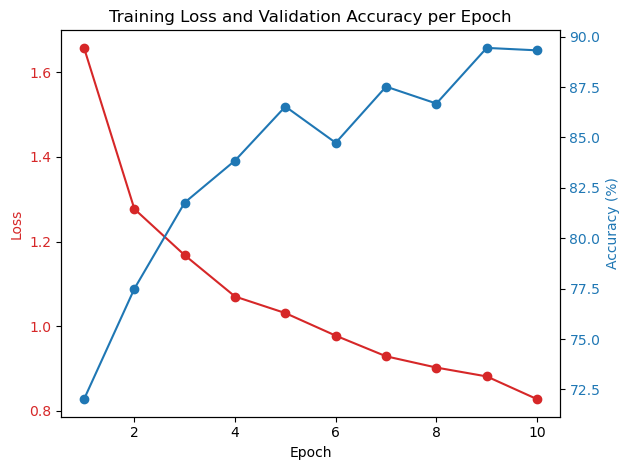

In [17]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

#Datos de entreno
losses = [
    1.6581053282275344, 1.2769390336878887, 1.1675355718249367,
    1.069811098503344, 1.0306137008068366, 0.9772289903649004,
    0.9284016446117714, 0.9017239758720645, 0.8807470211476991,
    0.826968271881987
]
accuracies = [
    72.01623815967524, 77.49661705006766, 81.77266576454669,
    83.85656292286875, 86.53585926928281, 84.73612990527741,
    87.52368064952638, 86.68470906630581, 89.44519621109607,
    89.3234100135318
]

fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, losses, color=color, marker='o', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epochs, accuracies, color=color, marker='o', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Loss and Validation Accuracy per Epoch')
fig.tight_layout()
plt.show()

Un entreno bastante decente, con el problema de una realentizacion muy grande al acercarse a 87, con mas epochs se mejora, 
pero no significativamente.

In [3]:
import torch

# Assuming 'model' is your trained model, 'optimizer' is your optimizer,
# and you have some metrics like 'best_accuracy' and 'final_epoch' available

# Function to save model and training state
def save_checkpoint(model, optimizer, best_accuracy, final_epoch, filename="final_model_checkpoint.pth.tar"):
    print("=> Saving final model checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),  # Model parameters
        "optimizer": optimizer.state_dict(),  # Optimizer parameters
        "best_accuracy": best_accuracy,  # Best observed accuracy
        "final_epoch": final_epoch  # The last epoch number
    }
    torch.save(checkpoint, filename)

# Example values, replace these with your actual training outcomes
best_accuracy = 93.99188092016239  # El mejor modelo que se consiguio con muchas epochs
final_epoch = 20  # Total number of epochs trained

# Call to save the checkpoint at the end of training
save_checkpoint(model, optimizer, best_accuracy, final_epoch)


=> Saving final model checkpoint


In [ ]:
model2 = models.mobilenet_v2(pretrained=True)
model2.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_dataset.classes))

# Move model to the appropriate device
model2.to(device)

Aqui lodeamos el modelo guardado

In [4]:
import torch
from torchvision import models
from torch import nn

# Assuming the model was MobileNetV2
def initialize_model(num_classes):
    model = models.mobilenet_v2(pretrained=False)  # Initially false to not load default weights
    # Adjust the classifier to match the number of classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Function to load the checkpoint into the model
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    final_epoch = checkpoint['final_epoch']
    print(f"=> Loaded checkpoint '{filepath}' (epoch {final_epoch}) with best accuracy: {best_accuracy}%")
    return model, optimizer, best_accuracy, final_epoch

# Number of classes (make sure this matches what was used in the saved model)
num_classes = 35  # Example value, set this to your actual number of classes

# Initialize a new model and optimizer
model2 = initialize_model(num_classes)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  # Ensure this matches the original optimizer's parameters

# Path to your saved checkpoint
checkpoint_path = 'final_model_checkpoint.pth.tar'

# Load the checkpoint into model2
model2, optimizer, best_accuracy, final_epoch = load_checkpoint(checkpoint_path, model2, optimizer)

# Ensure the model is in evaluation mode if you're not continuing training immediately
model2.eval()
model=model2
model.eval()
# Now `model2` is ready to be used for inference or to continue training


C:\Users\usuario\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=> Loaded checkpoint 'final_model_checkpoint.pth.tar' (epoch 20) with best accuracy: 93.99188092016239%


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
def get_class_names(data_dir):
    """
    Extracts sorted class names from a directory that contains one subdirectory per class.
    """
    class_names = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]
    return class_names
class_names = get_class_names(data_dir)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os


data_dir = './data/pets/formatted_images'
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def get_all_preds_labels(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    return all_preds.numpy(), all_labels.numpy()

predictions, labels = get_all_preds_labels(model, test_loader)

cm = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

KeyboardInterrupt: 

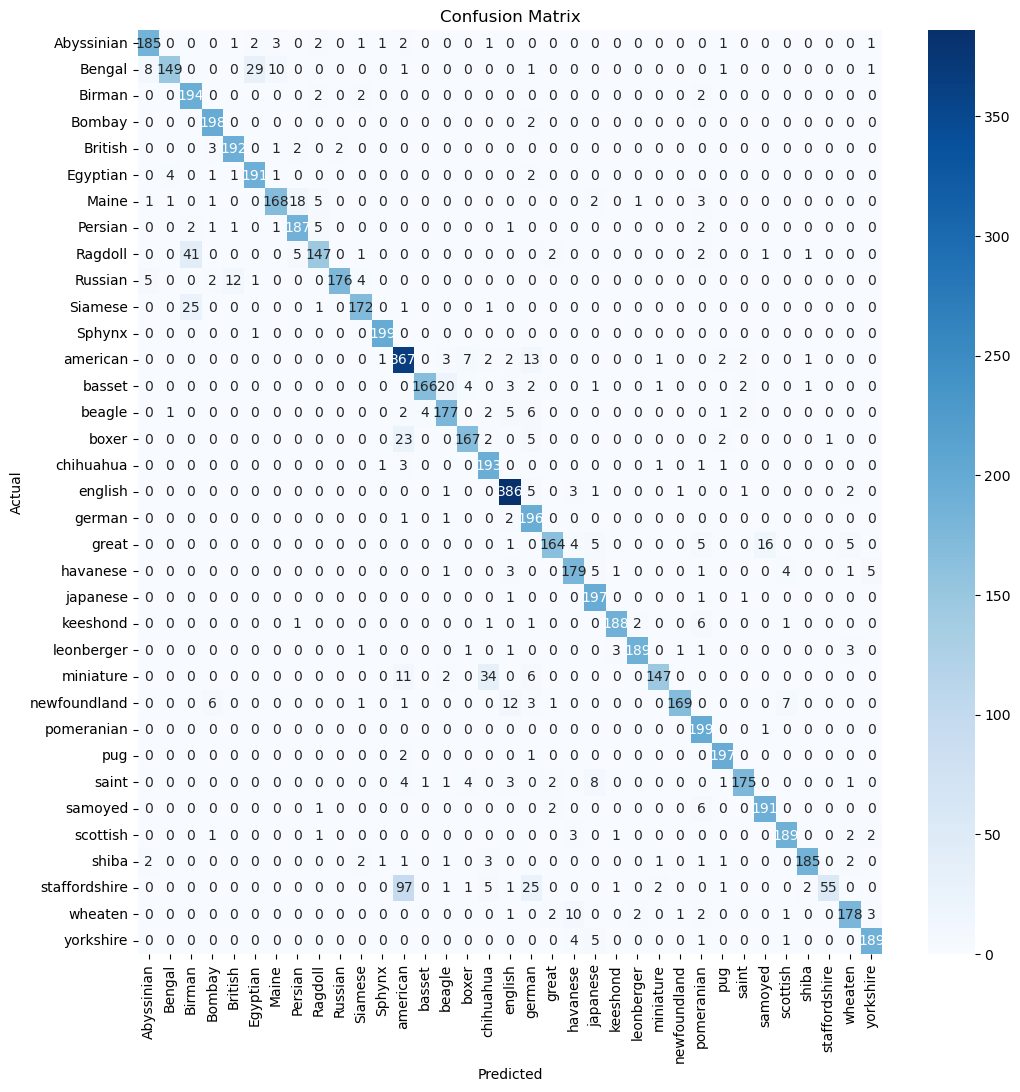

In [12]:
cm = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Aqui se ve un modelo algo peor que el que se llego a utilizar finalmente. este en particular tiene 89.3% de precision en validacion
y ahora que si es aceptable el resultado, podemos ver en el confusion matrix donde se concentra la mayor parte de errores, con la gran mayoria siendo errores en razas especificas, como puede ser el stafforshire, que se ve como tiene bastantes mas errores que aciertos. 
En caso de entrenar mas el modelo, mejoraria un poco, con el mejor de 20 epochs habiendo llegado a un 93% bajo, pero tambien tardaba demasiado en caso de 20 epochs, por lo que se entreno uno de 10 en este caso.
Despues se podra apreciar, pero hay muchas imagenes, que son erroneas en todos los modelos, con el indice 1 siendo un buen ejemplo, debido a la mala ilumincacion, el gato de la imagen, es muy parecido a otra especie

Enter the nth incorrect prediction to display:  10


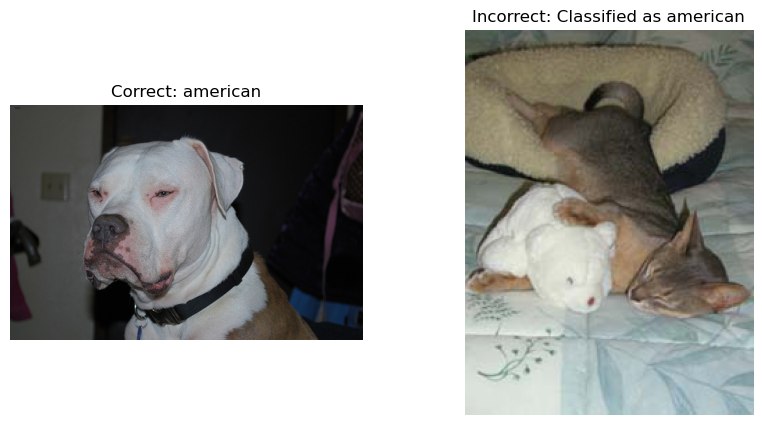

In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)  


nth_incorrect = int(input("Enter the nth incorrect prediction to display: "))


incorrect_count = 0
incorrect_image_path = None
correct_image_path = None
predicted_label_incorrect = None
correct_label = None

for (images, labels), paths in zip(loader, dataset.imgs):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    if preds != labels:
        incorrect_count += 1
        if incorrect_count == nth_incorrect:
            incorrect_image_path = paths[0]
            predicted_label_incorrect = preds.item()
            for (corr_images, corr_labels), corr_paths in zip(loader, dataset.imgs):
                corr_images, corr_labels = corr_images.to(device), corr_labels.to(device)
                corr_outputs = model(corr_images)
                _, corr_preds = torch.max(corr_outputs, 1)
                if corr_preds == corr_labels == predicted_label_incorrect:
                    correct_image_path = corr_paths[0]
                    correct_label = corr_labels.item()
                    break
            if correct_image_path:
                break

if not correct_image_path:
    print("No correct example found for the given class or nth incorrect too large.")


if incorrect_image_path and correct_image_path:
    incorrect_image = Image.open(incorrect_image_path)
    correct_image = Image.open(correct_image_path)


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(correct_image)
    axs[0].set_title(f'Correct: {dataset.classes[correct_label]}')
    axs[0].axis('off')

    axs[1].imshow(incorrect_image)
    axs[1].set_title(f'Incorrect: Classified as {dataset.classes[predicted_label_incorrect]}')
    axs[1].axis('off')

    plt.show()
else:
    print("Correct or incorrect image not found. Check the specified index.")

  0%|          | 0/1000 [00:00<?, ?it/s]

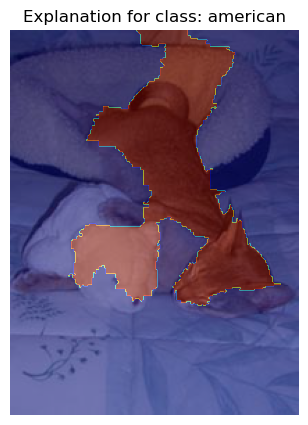

In [16]:
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from PIL import Image
import torch
from torchvision import transforms

def lime_explanation(model, image_path, class_names, num_samples=1000, num_features=5, top_labels=5):
    # Load the image from path and convert it to a numpy array
    image = Image.open(image_path)
    image_np = np.array(image)  # Convert PIL image to a numpy array

    explainer = lime_image.LimeImageExplainer()
    
    # Function to pass the model predictions to LIME
    def batch_predict(images):
        # Transform the PIL images to match model input
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        images = torch.stack([transform(Image.fromarray(img.astype('uint8'))) for img in images])
        images = images.to(device)
        model.eval()
        with torch.no_grad():
            preds = model(images)
        return preds.cpu().numpy()
    
    # Explain the prediction on the given image
    explanation = explainer.explain_instance(image_np,
                                             classifier_fn=batch_predict,
                                             top_labels=top_labels,
                                             hide_color=0,
                                             num_samples=num_samples,
                                             num_features=num_features)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=False)
    img_boundaries = mark_boundaries(temp / 2 + 0.5, mask, mode='thick', color=(1, 0, 0))

    # Combine the mask with the original image
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay the mask with transparency
    plt.title(f'Explanation for class: {class_names[explanation.top_labels[0]]}')
    plt.axis('off')
    plt.show()

# Usage

  # Change this path
lime_explanation(model, incorrect_image_path, class_names)


En la 10ma, por ejemplo, lo clasifica asi debido al peluche al lado del gato, no el gato en si. Con el gato probablemente siendo considerado como el color del torso de la raza, y el peluche su cara. Para estar seguros habria que ver los valores numericos de los pixeles, pero tampoco es necesario adentrarse tanto en un modelo que no llego a ser el final.
